In [7]:
from klkmeans import kl_kMeans

In [6]:
from helper import calculate_likelihood_em

In [138]:
from sklearn.externals import joblib
import pandas as pd

onlineEM = joblib.load('onlineEM_15_days_7_alligned.pkl')
test1 = joblib.load('groupped_data_15_days_00001_04320.pkl')
test2 = joblib.load('groupped_data_15_days_04321_08640.pkl')
test3 = joblib.load('groupped_data_15_days_08641_12960.pkl')
test4 = joblib.load('groupped_data_15_days_12961_17280.pkl')
groupped_data = pd.concat([test1, test2, test3, test4])
groupped_data1 = joblib.load('groupped_data_15_days_17281_21600.pkl')

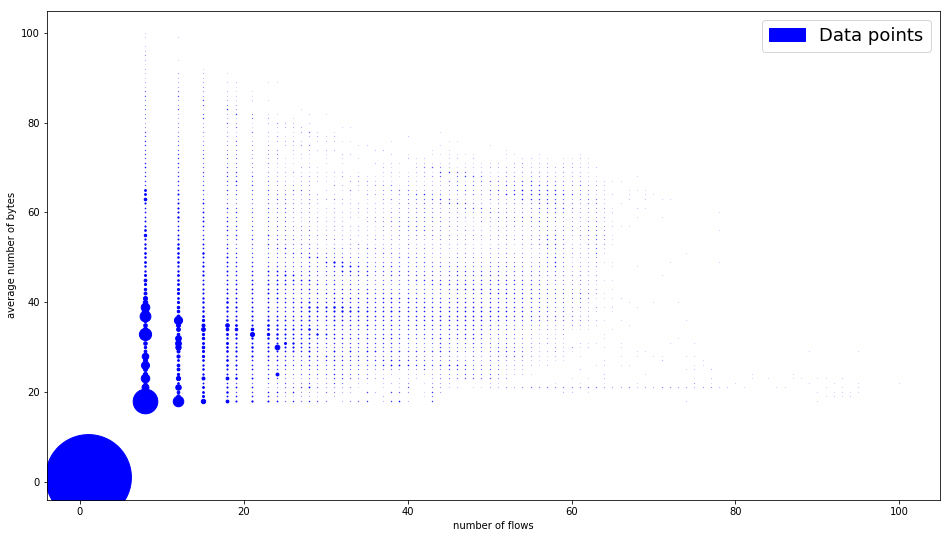

In [9]:
from plots import plot_points
%matplotlib inline

plot_points(groupped_data.values[:,:2])

Should this be done?

for host in onlineEM.hosts:
    tm = onlineEM.hosts[host]['transition_matrix']
    for l in  tm:
        l[l==0] = 0.00001

Or this?

for host in onlineEM.hosts:
    tm = onlineEM.hosts[host]['transition_matrix']
    for i, point in enumerate(onlineEM.hosts[host]['points_per_cluster']):
        if point == 0:
            tm[i] = np.zeros(onlineEM.m)

In [140]:
# Percentage of times each states leads to the same state
total = 0
same = 0

total_except_zero = 0
same_except_zero = 0
for host in onlineEM.hosts:
    tm = onlineEM.hosts[host]['transition_matrix']
    points_per_cluster = onlineEM.hosts[host]['points_per_cluster']
    total += sum(points_per_cluster)
    total_except_zero += sum(points_per_cluster[1:])
    i = 0
    for p, tvector in zip(points_per_cluster, tm):
        same += tm[i][i] * p
        if i != 0:
            same_except_zero += tm[i][i] * p
        i += 1

    
print('Percentage of times the next state is the same of the previous' , same / total * 100, '%')
print('Percentage of times the next state is the same of the previous not regarding zero traffic', 
      same_except_zero / total_except_zero * 100, '%')

Percentage of times the next state is the same of the previous 70.4634250851 %
Percentage of times the next state is the same of the previous not regarding zero traffic 29.4609448236 %


Initialize hmm 

In [141]:
import numpy as np

m = onlineEM.m

initialize = np.eye(m)

for i in range(m):
    for j in range(m):
        if i != j:
            initialize[i][j] = 0.5
            
    initialize[i] /= (1 + 0.5 * (m - 1))

In [142]:
for host in onlineEM.hosts:
    tm = onlineEM.hosts[host]['transition_matrix']
    for i, points in enumerate(onlineEM.hosts[host]['points_per_cluster']):
        tm[i] = tm[i] * (points / (points + 1)) + initialize[i] / (points + 1)

TESTING

In [13]:
kmeans = kl_kMeans(onlineEM, n_clusters=10, initial_centers=None, n_iters=15, n_runs=10)
C, assign = kmeans.run(verbose=1)

Starting run
Starting run
Starting run
Starting run


D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\klkmeans.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  total_distance += P[i] * log(P[i]/Q[i])


Starting run
Starting run
Starting run
Starting run
Starting run
Starting run


In [14]:
import matplotlib.pyplot as plt 
from pylab import rcParams

rcParams['figure.figsize'] = 16, 9
rcParams['font.size'] = 16

### Categorize hosts

In [143]:
distances = []
for host in onlineEM.hosts:
    distances.append([host, hmm_distance(onlineEM.hosts[host]['transition_matrix'], kmeans.centers[assign[host]])])

In [144]:
from plots import plot_points_host

In [145]:
# hosts with the higher distance respective to their kmeans center
sorted(distances, key=lambda x: -x[1])[:10]

[['C4797', 2.7079291940283143],
 ['C1340', 2.4839319677846854],
 ['C2986', 2.3539031288837884],
 ['C5089', 2.2817203556574888],
 ['C11573', 2.2580799544199812],
 ['C1823', 2.0779242989760585],
 ['C2320', 1.9837613404400569],
 ['C586', 1.909867858803044],
 ['C467', 1.8582645392288712],
 ['C528', 1.7952369110233688]]

In [147]:
sorted_distances = sorted(distances, key=lambda x: -x[1])

def percentage_distances(value):
    total = 0
    for k in kk:
        if k[1] < value:
            total += 1
    print('The percentage of transition matrices within a distance of', value,
          'from the kmeans center is', round(total/len(kk) * 100, 2), '%')
    
for i in np.arange(0.1, 2, 0.1):
    percentage_distances(i)

The percentage of transition matrices within a distance of 0.1 from the kmeans center is 45.41 %
The percentage of transition matrices within a distance of 0.2 from the kmeans center is 60.32 %
The percentage of transition matrices within a distance of 0.3 from the kmeans center is 75.09 %
The percentage of transition matrices within a distance of 0.4 from the kmeans center is 84.66 %
The percentage of transition matrices within a distance of 0.5 from the kmeans center is 90.17 %
The percentage of transition matrices within a distance of 0.6 from the kmeans center is 91.84 %
The percentage of transition matrices within a distance of 0.7 from the kmeans center is 94.05 %
The percentage of transition matrices within a distance of 0.8 from the kmeans center is 95.37 %
The percentage of transition matrices within a distance of 0.9 from the kmeans center is 96.25 %
The percentage of transition matrices within a distance of 1.0 from the kmeans center is 96.96 %
The percentage of transition m

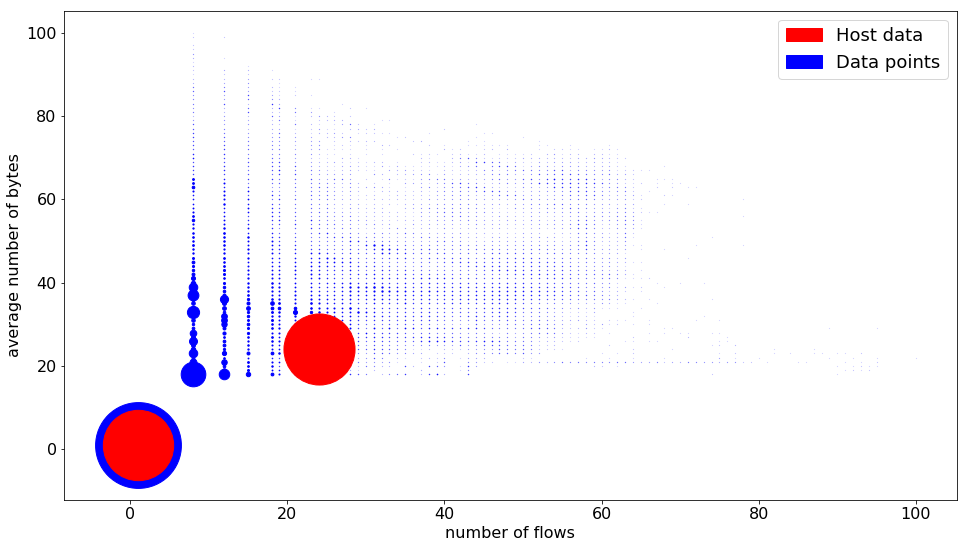

In [18]:
host = 'C4797'
plot_points_host(groupped_data.values[:, :2], hostData=groupped_data[groupped_data['source computer'] == host].values[:, :2])

In [19]:
from pylab import rcParams
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
import matplotlib.patches as mpatches

import seaborn as sns


colors = ['blue', 'red', 'green', 'yellow']
styles = ['-','--',':','-.']
rcParams['font.size'] = 16
# HOST and clusters
%matplotlib inline

def plot_transition_matrix(em, kmeans, host):
    rcParams['figure.figsize'] = 16, 9

    plt.subplot(1,2,1)
    ax = sns.heatmap(em.hosts[host]['transition_matrix'])
    plt.title('Host transition matrix')
    
    plt.subplot(1,2,2)
    ax = sns.heatmap(kmeans.centers[kmeans.assignments[host]])
    plt.title('Kmeans center transition matrix for center ' + str(kmeans.assignments[host]))
    plt.show()

In [20]:
onlineEM.lambdas

array([[0.0, 0.0],
       [55.35796116568266, 55.5106133016459],
       [7.490530257660513, 33.61984253955143],
       [9.192336417675378, 56.81490528692768],
       [19.384708222786813, 31.1284045736644],
       [36.29728398378874, 37.89205204878816],
       [7.0770611843650215, 18.8042149465344]], dtype=object)

In [23]:
onlineEM.hosts[host]['points_per_cluster']

array([  8.31800000e+03,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   8.96000000e+03,   0.00000000e+00,
         1.00000000e+00])

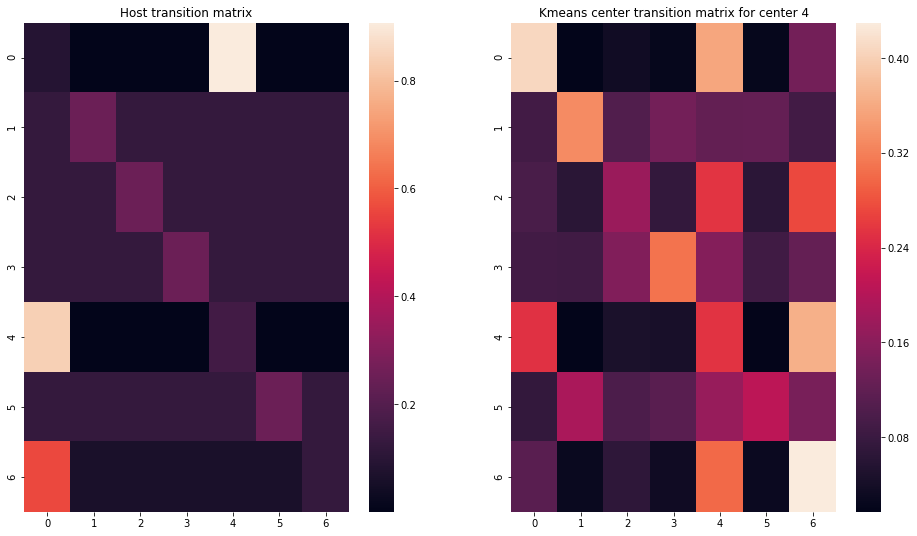

In [21]:
plot_transition_matrix(onlineEM, kmeans, host)

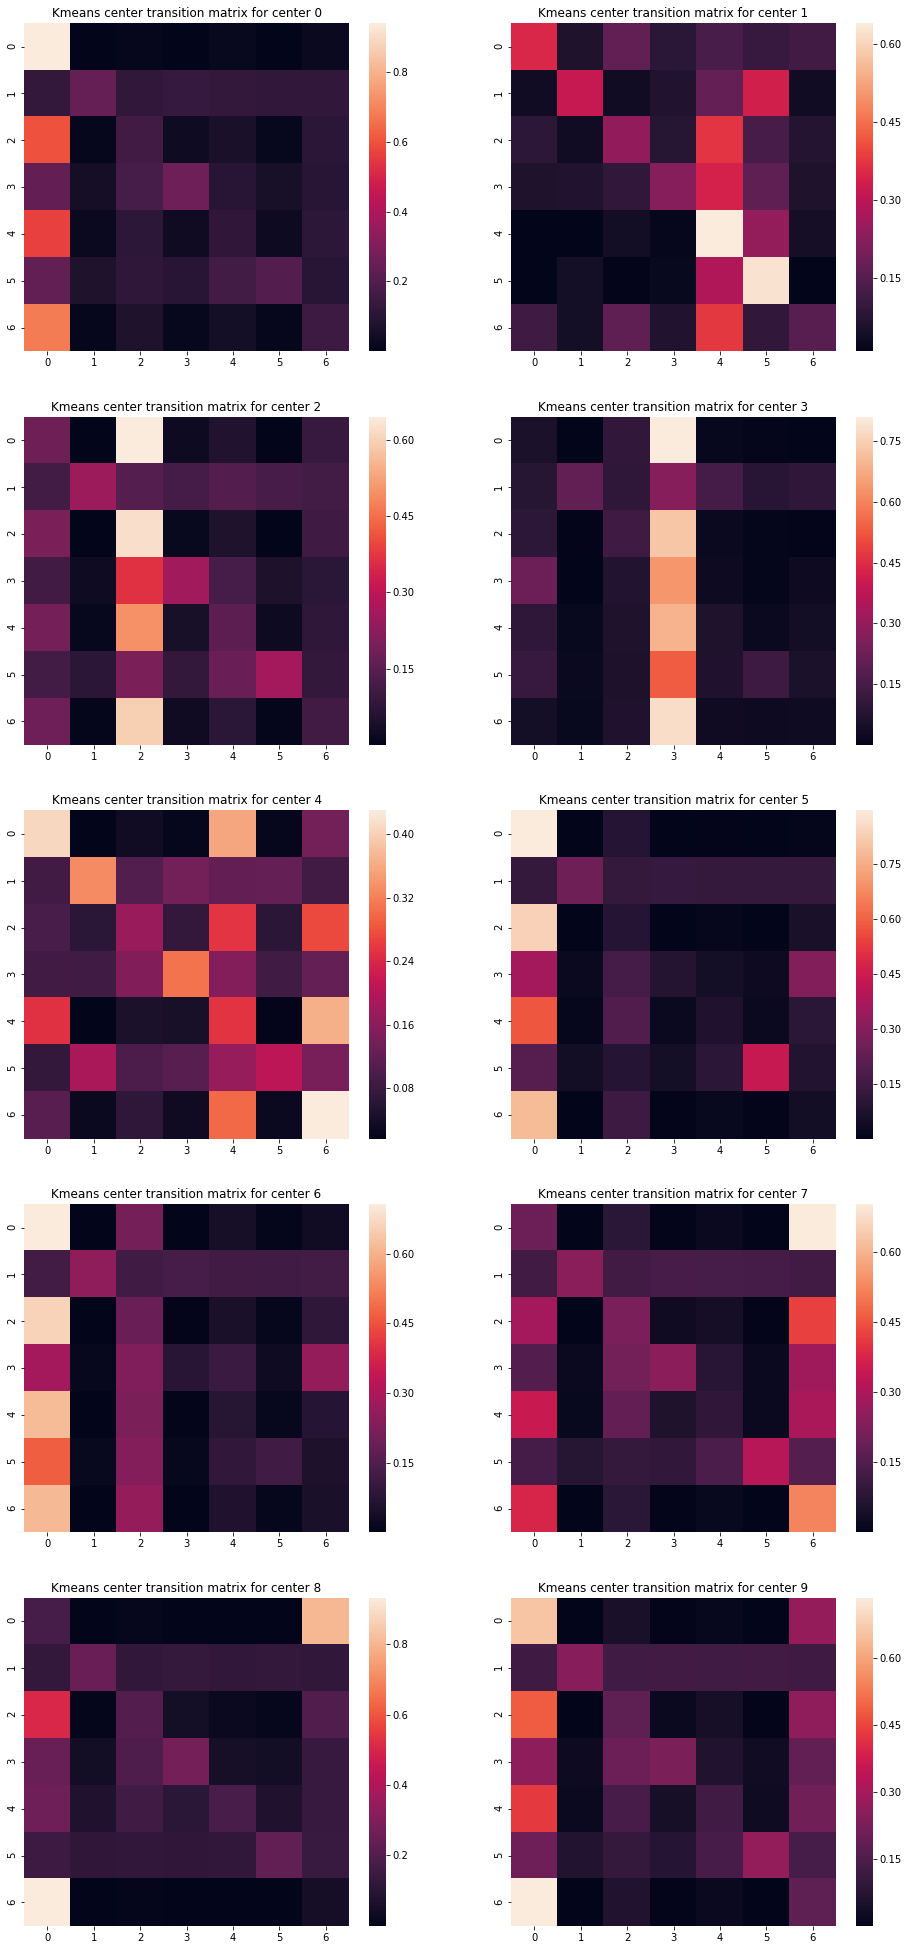

In [22]:
rcParams['figure.figsize'] = 16, 35
    
for i in range(10):
    plt.subplot(5,2,i+1)
    ax = sns.heatmap(kmeans.centers[i])
    plt.title('Kmeans center transition matrix for center ' + str(i))

plt.show()

In [50]:
import collections
    
centers = {}
for host in onlineEM.hosts:
    if kmeans.assignments[host] in centers:
        centers[kmeans.assignments[host]] += 1 
    else:
        centers[kmeans.assignments[host]] = 1


collections.OrderedDict(sorted(centers.items()))

OrderedDict([(0, 801),
             (1, 741),
             (2, 44),
             (3, 37),
             (4, 188),
             (5, 123),
             (6, 35),
             (7, 96),
             (8, 13),
             (9, 190)])

#### Create random traffic for a new host

In [51]:
# RANDOM COMBINATION OF FLOWS AND NUMBER OF BYTES
import random as ran
import random

random_flows = list(set(groupped_data['number of flows'].values))
random_average_bytes = list(set(groupped_data['mean(byte count)'].values))

anomalous_host = 'A1'
epochs = 1500

data = []
for i in range(epochs):
    #flows = ran.randint(1,50)
    #average_bytes = ran.randint(1,50)
    flows = random.choice(random_flows)
    average_bytes = random.choice(random_average_bytes)
    data.append([flows, average_bytes, anomalous_host])

    
for data_point in data:
    onlineEM.update_host(data_point)

D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\emClustering.py:209: RuntimeWarning: invalid value encountered in true_divide
  previous)


In [118]:
#RANDOM VALUE ENCOUNTERED IN GROUPED_DATA
import random as ran
import random

size = 10000

test_df = groupped_data.head(size)
unique_values = np.vstack({tuple(row) for row in test_df.values[:,:2]})

anomalous_host = 'A3'
epochs = 1500

data = []
for i in range(epochs):
    values = random.choice(unique_values)
    data.append([values[0], values[1], anomalous_host])

    
for data_point in data:
    onlineEM.update_host(data_point)

D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\emClustering.py:209: RuntimeWarning: invalid value encountered in true_divide
  previous)


In [119]:
tm = onlineEM.hosts[anomalous_host]['transition_matrix']
for i, points in enumerate(onlineEM.hosts[anomalous_host]['points_per_cluster']):
    tm[i] = tm[i] * (points / (points + 1)) + initialize[i] / (points + 1)

In [120]:
distances_for_anomalous_host = []
for i in range(len(kmeans.centers)):
    distances_for_anomalous_host.append([i, hmm_distance(onlineEM.hosts[anomalous_host]['transition_matrix'], 
                                         kmeans.centers[i])])

In [121]:
distances_for_anomalous_host.sort(key=lambda x: x[1])
distances_for_anomalous_host

[[1, 0.73822309132875996],
 [4, 1.6177998732345578],
 [2, 2.7983419197575028],
 [7, 3.5271532146124653],
 [0, 3.8448181158265688],
 [9, 3.8553330698457557],
 [3, 3.9280469055152203],
 [6, 4.3869153055370553],
 [8, 4.6168805136279145],
 [5, 4.6904665141365003]]

In [122]:
onlineEM.hosts[anomalous_host]['points_per_cluster']

array([   5.,   57.,  295.,   89.,  616.,  331.,  106.])

In [124]:
kmeans.assignments[anomalous_host] = 1

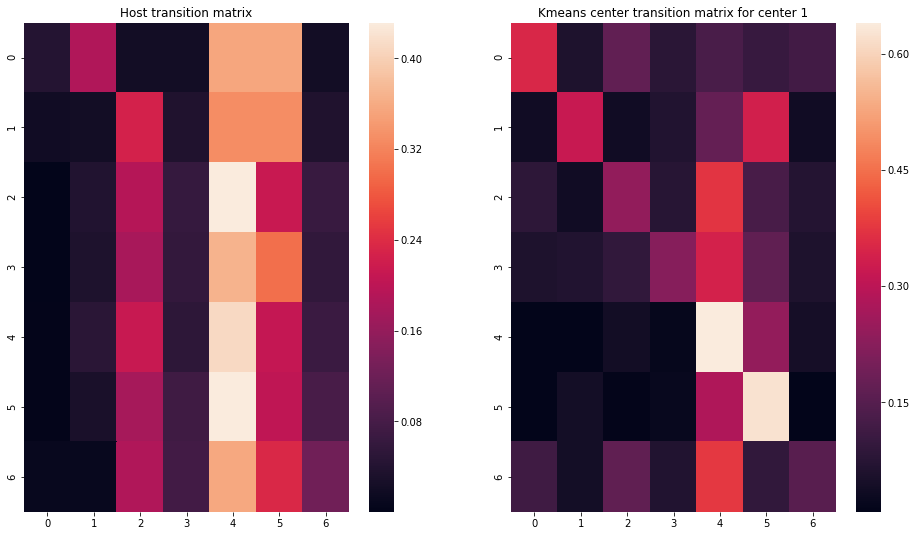

In [125]:
plot_transition_matrix(onlineEM, kmeans, anomalous_host)